In [223]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

def seed_everything(seed:int=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

warnings.filterwarnings('ignore')
seed_everything()

In [228]:
df = pd.read_csv('./dataset/ff.csv')
target = 'BE3_31'
idx = df[target].dropna().index
df = df.loc[idx]
df.head(3)

,year,HE_FEV1FVC,age,Total_slp_wk,sex,occp,EC1_1,cfam,marri_1,BH9_11,...,EC_pedu_1,EC_pedu_2,BS5_1,BD7_4,eq_5d,sm_present,mh_stress,cage,BE3_31,BE5_1
0,2007.0,0.699366,74.0,8.0,1.0,0.0,0.0,2.0,1.0,0.0,...,9.0,9.0,비흡연자,없었음,0.720,1,1.0,7,7.0,0.0
1,2007.0,0.699220,69.0,NaN,1.0,1.0,1.0,2.0,1.0,1.0,...,초졸이하,초졸이하,비흡연자,1년동안있었음,1.000,1,0.0,6,7.0,0.0
2,2007.0,0.698630,80.0,6.0,0.0,0.0,0.0,1.0,1.0,1.0,...,9.0,9.0,비흡연자,없었음,0.723,0,0.0,7,0.0,0.0


In [229]:
def make_targets(targets):
    return 1 if targets >=5 else 0

df[target] = df.apply(
    lambda row: make_targets(row[target]), axis=1
)

In [230]:
df[target].value_counts()

BE3_31
0    2652
1    2357
Name: count, dtype: int64

In [231]:
# 1차년도
NUMERIC = ['year', 'HE_FEV1FVC', 'age', 'Total_slp_wk']
CATEGORICAL = ['sex', 'occp', 'EC1_1', 'cfam', 'marri_1', 'BH9_11', 'HE_DM', 'DC6_dg', 'DF2_dg', 'HE_HPdg', 'BP5']
ONE_HOT = ['BS3_1', 'edu', 'BP1', 'D_1_1', 'LQ_1EQL', 'LQ_2EQL', 'LQ_3EQL', 'LQ_4EQL', 'LQ_5EQL', 'BO1_1', 'BO2_1']
# 2차년도
NUMERIC2 = ['DI1_ag', 'DE1_ag', 'LQ1_mn', 'BS6_2_1', 'BS6_3']
CATEGORICAL2 = ['DI1_pt', 'DE1_pt', 'DE1_3', 'BH1', 'BH2_61', 'LQ4_00', 'LQ4_05', 'LQ1_sb', 'MO1_wk', 'HE_cough1', 'HE_sput1', 'BD1', 'BD7_5', 'BP6_10', 'BP6_31']
ONE_HOT2 = ['DI1_2', 'EC_pedu_1', 'EC_pedu_2', 'BS5_1', 'BD7_4']
# 생성변수
NUMERIC3 = ['eq_5d']
CATEGORICAL3 = ['sm_present', 'mh_stress']
ONE_HOT3 = ['cage']
# Targets
TARGETS = ['BE3_31', 'BE5_1']

f_NUMERIC = (NUMERIC + NUMERIC2 + NUMERIC3).copy()
for idx in ['DI1_ag', 'DE1_ag']:
    f_NUMERIC.remove(idx)

f_CATEGORICAL = CATEGORICAL + CATEGORICAL2 + CATEGORICAL3.copy()
for idx in ['DC6_dg', 'DF2_dg', 'DI1_pt', 'DE1_pt', 'DE1_3', 'BP6_31']:
    f_CATEGORICAL.remove(idx)

f_ONE_HOT = ONE_HOT + ONE_HOT2 + ONE_HOT3.copy()
f_ONE_HOT.remove('DI1_2')

In [232]:
for col in df.columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [233]:
X = df.drop('BE3_31', axis=1)
y = df['BE3_31']

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)
print(f'train size: {len(train_X)}')
print(f'validate size: {len(val_X)}')

train size: 4007
validate size: 1002


In [235]:
def create_model_inputs(cols):
    inputs = {}
    for f in cols:
        if f in f_NUMERIC:
            inputs[f] = layers.Input(
                name=f, shape=(), dtype='float32'
            )
        else:
            inputs[f] = layers.Input(
                name=f, shape=(), dtype='string'
            )
    return inputs

In [ ]:
def encode_inputs(inputs, use_embedding=False):
    encoded_features = []
    for f in inputs:
        if f in f_CATEGORICAL:
            vocabulary = C

In [190]:
standard = StandardScaler()
onehot = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', standard, f_NUMERIC),
        ('onehot', onehot, f_ONE_HOT)
    ]
)
train_X = preprocessor.fit_transform(train_X)
val_X = preprocessor.transform(val_X)

In [191]:
# smote = SMOTE(random_state=42)
# adasyn = ADASYN(random_state=42)

# X_sm, y_sm = smote.fit_resample(train_X, train_y)
# X_ada, y_ada = adasyn.fit_resample(train_X, train_y)

In [216]:
# model = keras.Sequential(
#     [
#         keras.Input(shape=train_X.shape[1:]),
#         keras.layers.Dense(128, activation="relu"),
#         keras.layers.Dense(128, activation="relu"),
#         keras.layers.Dropout(0.3),
#         keras.layers.Dense(128, activation="relu"),
#         keras.layers.Dropout(0.3),
#         keras.layers.Dense(1, activation="sigmoid"),
#     ]
# )
model = keras.Sequential(
    [
        keras.Input(shape=train_X.shape[1:]),
        keras.layers.Dense(128),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 128)               9984      
                                                                 
 batch_normalization_2 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 re_lu_2 (ReLU)              (None, 128)               0         
                                                                 
 dropout_37 (Dropout)        (None, 128)               0         
                                                                 
 dense_73 (Dense)            (None, 128)               16512     
                                                                 
 batch_normalization_3 (Bat  (None, 128)               512       
 chNormalization)                                    

In [ ]:
def create_widedeep():
    inputs = 

In [217]:
metrics = [
    # keras.metrics.FalseNegatives(name="fn"),
    # keras.metrics.FalsePositives(name="fp"),
    # keras.metrics.TrueNegatives(name="tn"),
    # keras.metrics.TruePositives(name="tp"),
    # keras.metrics.Precision(name="precision"),
    # keras.metrics.Recall(name="recall"),
    keras.metrics.Accuracy(name="acc"),
    # keras.metrics.CategoricalAccuracy(name="cacc"),
    keras.metrics.AUC(name="auc"),
]
model.compile(
    # optimizer=keras.optimizers.AdamW(1e-4), loss="categorical_crossentropy", metrics=metrics
    optimizer=keras.optimizers.AdamW(1e-4), loss="binary_crossentropy", metrics=['acc']
)
# model.compile(
#     optimizer=keras.optimizers.AdamW(1e-4), loss=keras.losses.CategoricalFocalCrossentropy(), metrics=metrics
# )
# callback = keras.callbacks.ModelCheckpoint('./auto.h5', save_best_only=True)
# class_weight = {
#     0: 1. / train_y.value_counts()[0], 
#     1: 1. / train_y.value_counts()[1],
# }

hist = model.fit(
    train_X,
    train_y,
    batch_size=128,
    epochs=200,
    verbose=2,
    validation_data=(val_X, val_y),
    # class_weight=class_weight,
)

Epoch 1/200
32/32 - 2s - loss: 0.7644 - acc: 0.5141 - val_loss: 0.7006 - val_acc: 0.4850 - 2s/epoch - 63ms/step
Epoch 2/200
32/32 - 0s - loss: 0.7627 - acc: 0.5106 - val_loss: 0.6969 - val_acc: 0.4970 - 445ms/epoch - 14ms/step
Epoch 3/200
32/32 - 0s - loss: 0.7523 - acc: 0.5061 - val_loss: 0.6944 - val_acc: 0.5120 - 425ms/epoch - 13ms/step
Epoch 4/200
32/32 - 0s - loss: 0.7402 - acc: 0.5166 - val_loss: 0.6924 - val_acc: 0.5269 - 394ms/epoch - 12ms/step
Epoch 5/200
32/32 - 0s - loss: 0.7414 - acc: 0.5278 - val_loss: 0.6911 - val_acc: 0.5399 - 385ms/epoch - 12ms/step
Epoch 6/200
32/32 - 0s - loss: 0.7433 - acc: 0.5171 - val_loss: 0.6902 - val_acc: 0.5419 - 386ms/epoch - 12ms/step
Epoch 7/200
32/32 - 0s - loss: 0.7302 - acc: 0.5376 - val_loss: 0.6892 - val_acc: 0.5379 - 384ms/epoch - 12ms/step
Epoch 8/200
32/32 - 0s - loss: 0.7169 - acc: 0.5465 - val_loss: 0.6890 - val_acc: 0.5449 - 385ms/epoch - 12ms/step
Epoch 9/200
32/32 - 0s - loss: 0.7351 - acc: 0.5206 - val_loss: 0.6887 - val_acc: 0

In [182]:
train_y.value_counts()

BE3_31
0.0    2121
1.0    1886
Name: count, dtype: int64

In [218]:
# pred = model.predict(train_X)
pred = np.squeeze(np.where(model.predict(train_X) >= .5, 1, 0))
# print(classification_report(tf.argmax(pred, axis=1), train_y))
print(classification_report(pred, train_y))

126/126 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.75      0.72      0.73      2211
           1       0.67      0.70      0.69      1796

    accuracy                           0.71      4007
   macro avg       0.71      0.71      0.71      4007
weighted avg       0.71      0.71      0.71      4007



In [219]:
# pred = model.predict(val_X)
pred = np.squeeze(np.where(model.predict(val_X) >= .5, 1, 0))
# print(classification_report(tf.argmax(pred, axis=1), val_y))
print(classification_report(pred, val_y))

32/32 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.64      0.58      0.61       587
           1       0.48      0.54      0.51       415

    accuracy                           0.56      1002
   macro avg       0.56      0.56      0.56      1002
weighted avg       0.57      0.56      0.57      1002



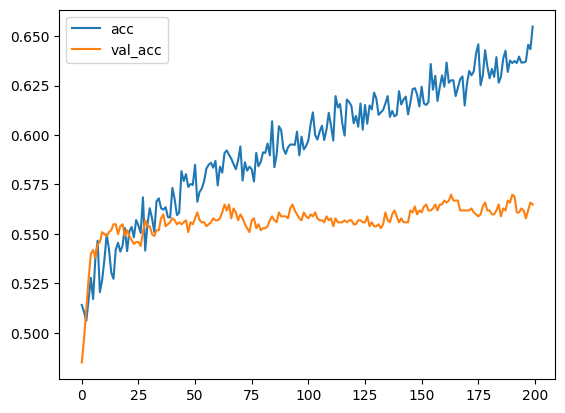

In [220]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['acc', 'val_acc'])